In [1]:
# 混合高斯模型（以一维两高斯混合模型为例）
import numpy as np

def Gaussian(x, mu, sigma): # 计算高斯分布密度
    
    GaussianP = 1 / (sigma * np.sqrt(2 * np.pi)) \
                * np.exp(-1 * np.square(x - mu) / (2 * np.square(sigma)))
    
    return GaussianP

def EM_Algorithm(Data,theta,times): # EM算法
    """
    输入样本数据Data和迭代参数theta=[pi,mu1,sigma1,mu2,sigma2]
    """
    def E_step(x,theta): # E步，计算pi的期望值（进而可知Q函数）
        exp_pi = theta[0]*Gaussian(x,theta[1],theta[2])+(1-theta[0])*Gaussian(x,theta[3],theta[4])
        exp_pi1 = (theta[0]*Gaussian(x,theta[1],theta[2]))/exp_pi
        exp_pi2 = (1-theta[0])*Gaussian(x,theta[3],theta[4])/exp_pi
        return(exp_pi1, exp_pi2)
    
    def M_step(Data,theta): # M步，根据优化计算结果更新参数
        theta_new = []
        length = len(Data)
        sum_exp_pi1,sum_exp_pi2 = 0,0; sum11,sum12 = 0,0; sum21,sum22 = 0,0
        for i in range(length):
            sum_exp_pi1 =  sum_exp_pi1+E_step(Data[i],theta)[0]
            sum_exp_pi2 =  sum_exp_pi2+E_step(Data[i],theta)[1]
            sum11 = sum11+E_step(Data[i],theta)[0]*Data[i]
            sum21 = sum21+E_step(Data[i],theta)[1]*Data[i]
            sum12 = sum12+E_step(Data[i],theta)[0]*(Data[i]-theta[1])*(Data[i]-theta[1])
            sum22 = sum12+E_step(Data[i],theta)[1]*(Data[i]-theta[3])*(Data[i]-theta[3])
        theta_new.append(sum_exp_pi1/length)
        theta_new.append(sum11/sum_exp_pi1)
        theta_new.append(np.sqrt(sum12/sum_exp_pi1))
        theta_new.append(sum21/sum_exp_pi2)
        theta_new.append(np.sqrt(sum12/sum_exp_pi2))
        return theta_new
    
    for j in range(times): # 迭代计算，直至达到预定次数
        theta = M_step(Data,theta)
    return theta

[0.40952614686377653, -2.816358376959309, 1.0903358677634654, 3.24818800536025, 0.9080312202724807]


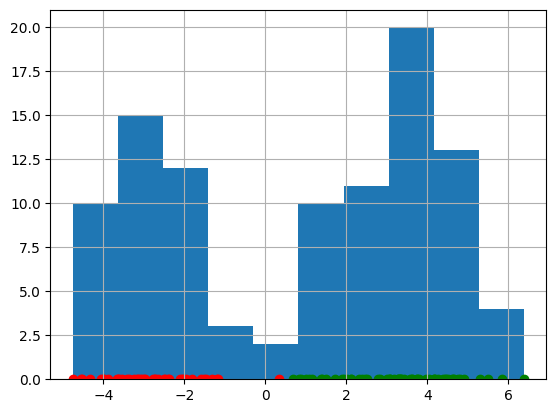

In [9]:
# 输入x.csv的数据，假定是二高斯混合分布模型
import pandas as pd
import matplotlib.pyplot as plt

Data = pd.read_csv("x.csv",header=0)["x"]
"""
由直方图可以较明显看出数据近似来自于两个不同的高斯分布，不妨猜测：
高斯分布1: mu1 = -3; sigma1 = 1
高斯分布2: mu2 = 3; sigma2 = 1
下面由混合高斯模型EM算法来估算参数
"""
Theta = np.array([0.4,-3,1,3,1])
theta_new = EM_Algorithm(Data,Theta,100)
print(theta_new)
"""
经过一百次迭代后，结果为:
高斯分布1: mu1 = -2.82; sigma1 = 1.09
高斯分布2: mu2 = 3.25; sigma2 = 0.91
结果还是挺符合观察情况

最后，我们用混合高斯模型进行聚类，基本原理是求每个样本点对应不同分布的期望pi值，看哪个更大
"""
def Cluster(Data,Theta,times): # 基于混合高斯模型的聚类
    Label = []
    Theta = np.array([0.4,-3,1,3,1])
    theta_new = EM_Algorithm(Data,Theta,100)
    length = len(Data)
    for i in range(length):
        exp_pi1 = theta_new[0]*Gaussian(Data[i],theta_new[1],theta_new[2])
        exp_pi2 = (1-theta_new[0])*Gaussian(Data[i],theta_new[3],theta_new[4])
        if exp_pi1>=exp_pi2:
            Label.append(1)
        else:
            Label.append(2)
    return Label
Label = Cluster(Data,Theta,100) # 聚类结果

plt.hist(Data,)
length = len(Data)
for i in range(length):
    if Label[i]==1:
        plt.scatter(Data[i],0,color="red")
    else:
        plt.scatter(Data[i],0,color="green")
plt.grid()
plt.show() # 输出聚类结果